# Load runs statistics

The code below reads the results of our experiment already parsed from WandB and stored in `.csv` format.

If you want to parse your runs from WandB to work with your own results please see the bottom of this notebook.

## Load already parsed runs

In [1]:
import pandas as pd

runs_df = pd.read_csv("non_ensemble_runs.csv")

# scores are saved as a list of floats, pandas interprets them as strings
runs_df['scores'] = runs_df['scores'].apply(eval)
runs_df

,seed,model,dataset,n_shots,precision,batch_size,template_seed,prediction_method,selection_method,scores
0,59,llama-65b,dbpedia,4,fp16,16,13,direct_False,random,"[0.519, 0.562, 0.562, 0.559, 0.35, 0.534, 0.49..."
1,59,llama-2-70b-hf,dbpedia,4,fp16,16,13,direct_False,random,"[0.585, 0.637, 0.637, 0.624, 0.592, 0.576, 0.5..."
2,59,llama-65b,dbpedia,4,fp16,16,21,direct_False,random,"[0.564, 0.576, 0.244, 0.535, 0.396, 0.508, 0.0..."
3,59,llama-2-70b-hf,dbpedia,4,fp16,16,21,direct_False,random,"[0.561, 0.615, 0.478, 0.584, 0.568, 0.6, 0.367..."
4,59,llama-2-70b-hf,dbpedia,4,fp16,16,21,direct_False,implicitly_topic_models,"[0.503, 0.507, 0.354, 0.492, 0.449, 0.504, 0.4..."
...,...,...,...,...,...,...,...,...,...,...
3115,59,falcon-1b,sst2,2,fp16,64,59,direct_False,random,"[0.5470183486238532, 0.8555045871559633, 0.638..."
3116,59,bloom-1.7b,sst2,4,fp16,32,59,direct_False,random,"[0.5091743119266054, 0.8600917431192661, 0.727..."
3117,59,bloom-3b,sst2,2,fp16,32,59,direct_False,random,"[0.5149082568807339, 0.875, 0.5103211009174312..."
3118,59,llama-2-7b-hf,sst2,2,fp16,16,59,direct_False,random,"[0.5091743119266054, 0.6215596330275229, 0.674..."


# Auxiliary functions

In [2]:
# proper display of models/methods/datasets names
dataset_name = {"sst2": "SST-2", "dbpedia": "DBPedia 14", "trec": "TREC", "agnews": "AG News"}
prediction_method_name = {'direct_False': 'Direct', 'channel_True': 'Channel', 'calibrate_True': 'Calibration'}
selection_method_name = {'random': 'Random', 'implicitly_topic_models': 'ITM', 'z-ICL': 'z-ICL'}

model_name = {
    'gptj': 'GPT-J',
    'gpt-neox': 'GPT-NeoX',
    'opt-6.7b': 'OPT 6.7B',
    'opt-30b': 'OPT 30B',
    'opt-66b': 'OPT 66B',
    'bloom-1.7b': 'BLOOM 1.7B',
    'bloom-3b': 'BLOOM 3B',
    'bloom-7.1b': 'BLOOM 7.1B',
    'pythia-6.9b': 'Pythia 6.9B',
    'pythia-12b': 'Pythia 12B',
    'llama-7b': 'LLaMA 7B',
    'llama-13b': 'LLaMA 13B',
    'llama-30b': 'LLaMA 30B',
    'llama-65b': 'LLaMA 65B',
    'falcon-1b': 'Falcon 1B',
    'falcon-7b': 'Falcon 7B',
    'falcon-40b': 'Falcon 40B',
    'llama-2-13b-hf': "LLaMA 2 13B",
    'llama-2-70b-hf': "LLaMA 2 70B",
}
family_enders = {'gpt-neox', 'opt-66b', 'bloom-7.1b', 'pythia-12b', 'cerebras-13b', 'llama-65b', 'falcon-40b',
                }
main_models = [
    'falcon-1b', 'falcon-7b', 'falcon-40b',
    'llama-2-13b-hf', 'llama-2-70b-hf',           
              ]

In [3]:
import numpy as np

def get_runs(config):
    found_runs = runs_df
    
    for column in config:
        if isinstance(config[column], list):
            cond = found_runs[column].isin(config[column])
        else:
            cond = found_runs[column] == config[column]
            
        found_runs = found_runs.loc[cond]
    
    return found_runs

def get_scores(runs, config, seeds_range=[59, 13, 21], verbose=True):
    scores = []
    
    for seed in seeds_range:
        seed_runs = runs.loc[runs['seed'] == seed]
        if len(seed_runs) == 0 and verbose:
            print(config)
            print(f"seed_range: {seeds_range}, no seed: {seed}")
        else:
            scores.append(seed_runs.iloc[0]['scores'])
    
    return scores

def report_scores(scores, report="mean_std"):
    if len(scores) > 0:
        if report == "mean_std":
            return np.mean(scores), np.std(scores)
        elif report == "worst_best":
            return np.mean(np.min(scores, axis=0)), np.mean(np.max(scores, axis=0))
        elif report == "iqr":
            return (np.percentile(scores, 25, interpolation='midpoint'), 
                    np.percentile(scores, 75, interpolation='midpoint'))
    else:
        return np.nan, np.nan
    
def format_res(inp, report="mean_std"):
    a, b = inp
    if report == "mean_std":
        return f"{a:.2f}\\textsubscript{{{b:.2f}}}"
    else:
        return f"{a:.2f}/{b:.2f}"

# Tables 3, 11. Baseline results

In [4]:
from IPython.display import display
from collections import defaultdict

datasets_tables = defaultdict(list)

# table 3: models_range = main_models
# table 11: models_range = model_name
models_range = main_models

datasets = list(dataset_name.keys())
# print table header
print("""\\multirow{2}{*}{Model} &
\\multicolumn{2}{c}{SST-2} &
\\multicolumn{2}{c}{DBPedia} & 
\\multicolumn{2}{c}{AGNews} & 
\\multicolumn{2}{c}{TREC} \\\\
\\cmidrule(lr){2-4}\\cmidrule(lr){5-7}\\cmidrule(lr){8-10}
\\cmidrule(lr){11-13}
& 0-shot & 2-shot & 4-shot & 0-shot & 2-shot & 4-shot & 0-shot & 2-shot & 4-shot & 0-shot & 2-shot & 4-shot\\\\
\\midrule""")
for model in models_range:
    print(model_name[model], end=" & ")
    for dataset in datasets:
        res_table = []
    
        config = {'dataset': dataset, 'model': model, 'n_shots': 0,
                  'prediction_method': 'direct_False', 'template_seed': 59,
                 }
        zero_shot_scores = get_scores(get_runs(config), config, verbose=False, seeds_range=[59])
        zero_shot_res = report_scores(zero_shot_scores, report="mean_std")
        
        config['n_shots'] = 2
        config['selection_method'] = 'random'
        two_shot_scores = get_scores(get_runs(config), config, verbose=False)
        two_shot_res = report_scores(two_shot_scores, report="mean_std")
        
        config['n_shots'] = 4
        four_shot_scores = get_scores(get_runs(config), config, verbose=False)
        four_shot_res = report_scores(four_shot_scores, report="mean_std")
        
        datasets_tables[dataset].append({"model": model_name[model], 
                                         "0": f"{zero_shot_res[0]:.2f} ± {zero_shot_res[1]:.2f}", 
                                         "2": f"{two_shot_res[0]:.2f} ± {two_shot_res[1]:.2f}",
                                         "4": f"{four_shot_res[0]:.2f} ± {four_shot_res[1]:.2f}",
                                        })
        end = " & " if dataset != datasets[-1] else " \\\\\n"
        print(
            format_res(zero_shot_res),
            format_res(two_shot_res), 
            format_res(four_shot_res), 
              sep=" & ", end=end,
        )
    if model in family_enders:
        print("\\midrule")

\multirow{2}{*}{Model} &
\multicolumn{2}{c}{SST-2} &
\multicolumn{2}{c}{DBPedia} & 
\multicolumn{2}{c}{AGNews} & 
\multicolumn{2}{c}{TREC} \\
\cmidrule(lr){2-4}\cmidrule(lr){5-7}\cmidrule(lr){8-10}
\cmidrule(lr){11-13}
& 0-shot & 2-shot & 4-shot & 0-shot & 2-shot & 4-shot & 0-shot & 2-shot & 4-shot & 0-shot & 2-shot & 4-shot\\
\midrule
Falcon 1B & 0.72\textsubscript{0.08} & 0.65\textsubscript{0.17} & 0.77\textsubscript{0.15} & 0.54\textsubscript{0.03} & 0.36\textsubscript{0.25} & 0.44\textsubscript{0.23} & 0.24\textsubscript{0.04} & 0.26\textsubscript{0.09} & 0.31\textsubscript{0.09} & 0.68\textsubscript{0.04} & 0.52\textsubscript{0.17} & 0.56\textsubscript{0.19} \\
Falcon 7B & 0.72\textsubscript{0.09} & 0.77\textsubscript{0.16} & 0.83\textsubscript{0.16} & 0.50\textsubscript{0.06} & 0.40\textsubscript{0.21} & 0.49\textsubscript{0.18} & 0.31\textsubscript{0.04} & 0.32\textsubscript{0.09} & 0.39\textsubscript{0.11} & 0.75\textsubscript{0.06} & 0.51\textsubscript{0.20} & 0.60\textsubscri

In [5]:
for dataset in datasets:
    print(dataset)
    display(pd.DataFrame(datasets_tables[dataset]))

sst2


,model,0,2,4
0,Falcon 1B,0.72 ± 0.08,0.65 ± 0.17,0.77 ± 0.15
1,Falcon 7B,0.72 ± 0.09,0.77 ± 0.16,0.83 ± 0.16
2,Falcon 40B,0.76 ± 0.05,0.79 ± 0.17,0.92 ± 0.07
3,LLaMA 2 13B,0.77 ± 0.09,0.79 ± 0.17,0.92 ± 0.07
4,LLaMA 2 70B,0.85 ± 0.05,0.83 ± 0.14,0.92 ± 0.09


dbpedia


,model,0,2,4
0,Falcon 1B,0.54 ± 0.03,0.36 ± 0.25,0.44 ± 0.23
1,Falcon 7B,0.50 ± 0.06,0.40 ± 0.21,0.49 ± 0.18
2,Falcon 40B,0.45 ± 0.03,0.42 ± 0.15,0.54 ± 0.06
3,LLaMA 2 13B,0.45 ± 0.03,0.40 ± 0.15,0.51 ± 0.09
4,LLaMA 2 70B,0.48 ± 0.04,0.46 ± 0.15,0.60 ± 0.05


trec


,model,0,2,4
0,Falcon 1B,0.24 ± 0.04,0.26 ± 0.09,0.31 ± 0.09
1,Falcon 7B,0.31 ± 0.04,0.32 ± 0.09,0.39 ± 0.11
2,Falcon 40B,0.31 ± 0.07,0.36 ± 0.07,0.46 ± 0.10
3,LLaMA 2 13B,0.33 ± 0.03,0.32 ± 0.09,0.41 ± 0.14
4,LLaMA 2 70B,0.34 ± 0.03,0.41 ± 0.07,0.51 ± 0.06


agnews


,model,0,2,4
0,Falcon 1B,0.68 ± 0.04,0.52 ± 0.17,0.56 ± 0.19
1,Falcon 7B,0.75 ± 0.06,0.51 ± 0.20,0.60 ± 0.19
2,Falcon 40B,0.75 ± 0.07,0.64 ± 0.23,0.75 ± 0.09
3,LLaMA 2 13B,0.75 ± 0.07,0.70 ± 0.15,0.76 ± 0.09
4,LLaMA 2 70B,0.78 ± 0.06,0.76 ± 0.14,0.82 ± 0.05


# Prediction Methods

## Figure 2

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import (plot, show, savefig, xlim, figure, 
                   ylim, legend, boxplot, setp, axes)

blue, red, green = '#1f77b4', '#ff7f0e', '#2ca02c'
# function for setting the colors of the box plots pairs
def set_box_colors(bp, outliers=True):
    setp(bp['boxes'][0], color=blue)
    setp(bp['caps'][0], color=blue)
    setp(bp['caps'][1], color=blue)
    setp(bp['whiskers'][0], color=blue)
    setp(bp['whiskers'][1], color=blue)
    
    setp(bp['medians'][0], color=blue)

    setp(bp['boxes'][1], color=red)
    setp(bp['caps'][2], color=red)
    setp(bp['caps'][3], color=red)
    setp(bp['whiskers'][2], color=red)
    setp(bp['whiskers'][3], color=red)
    setp(bp['medians'][1], color=red)
    
    setp(bp['boxes'][2], color=green)
    setp(bp['caps'][4], color=green)
    setp(bp['caps'][5], color=green)
    setp(bp['whiskers'][4], color=green)
    setp(bp['whiskers'][5], color=green)
    setp(bp['medians'][2], color=green)

    if outliers:
        setp(bp['fliers'][0], color=blue)
        setp(bp['fliers'][1], color=red)
        setp(bp['fliers'][2], color=green)
    
def set_ticks(ax, models_range, angle=45):
    visible_ticks = [j * 6 + 2 for j in range(len(models_range))]
    ax.set_xticks(visible_ticks,
                  labels=[model_name[x] for x in models_range],
                  rotation=angle, ha="center")
    
def boxplot(models_range=model_name.keys(), datasets_range=datasets, 
            n_shots=2, orientation='horizontal', methods_range=prediction_method_name,
            figsize=[5,5], outliers=True, angle=45, bottom_sep=0.1):
    selection_method = 'random' if n_shots > 0 else "0-shot"
    seeds_range = [59, 13, 21] if n_shots > 0 else [59]
    
    fig = plt.figure(figsize=figsize)
    plt.tight_layout()
    for i, dataset in enumerate(datasets_range, 1):
        if orientation != 'horizontal':
            ax = fig.add_subplot(len(datasets_range), 1, i)
        else:
            ax = fig.add_subplot(1, len(datasets_range), i)

        method_scores = defaultdict(list)
        for j, model in enumerate(models_range):
            for method in methods_range:
                if 'direct_False' in methods_range:
                    # iterate over prediction methods
                    config = {'dataset': dataset, 'model': model, 'prediction_method': method, 
                              'selection_method': selection_method, 'n_shots':n_shots, 'template_seed': 59,
                             }
                else:
                    config = {'dataset': dataset, 'model': model, 'prediction_method': 'direct_False', 
                              'selection_method': method, 'n_shots':n_shots, 'template_seed': 59,
                             }
                method_runs = get_runs(config)
                scores = []
                for score in get_scores(method_runs, config, seeds_range=seeds_range):
                    scores.extend(score)
                    
                method_scores[method].append(scores)
            bp = ax.boxplot([method_scores[method][j] for method in methods_range],
                             positions=[j * 6 + 1, j * 6 + 2, j * 6 + 3], widths = 0.6, showfliers=outliers)
            set_box_colors(bp)
    
        # set axes limits and labels
        xlim(-1, 6 * len(models_range) + 1)
        # ylim(0,9)
        if orientation != "horizontal":
            if i == len(datasets_range):
                set_ticks(ax, models_range, angle)
            else:
                ax.set_xticks([])
        else:
            set_ticks(ax, models_range, angle)
            
        # draw temporary red and blue lines and use them to create a legend
        hB, = plot([0.5,.5], c=blue)
        hR, = plot([.5,.5], c=red)
        hG, = plot([.5,.5], c=green)
        if i != len(datasets_range):
            hB.set_visible(False)
            hR.set_visible(False)
            hG.set_visible(False)
        
        if i == 1:
            ax.set_ylabel('Accuracy')
        # ax.set_ylim(0, 60)
        ax.set_title(dataset_name[dataset])

    # code for a single legend
    lines = (hB, hR, hG)
    labels = (methods_range[method] for method in methods_range)
    bb = (fig.subplotpars.left, 
          fig.subplotpars.bottom - bottom_sep,
          fig.subplotpars.right-fig.subplotpars.left,
          .1)
    fig.legend(lines, labels, ncol=3,
               bbox_to_anchor=bb,
               borderaxespad=0., bbox_transform=fig.transFigure,
               loc='lower center',
              )
    hB.set_visible(False)
    hR.set_visible(False)
    hG.set_visible(False)
    
    return fig

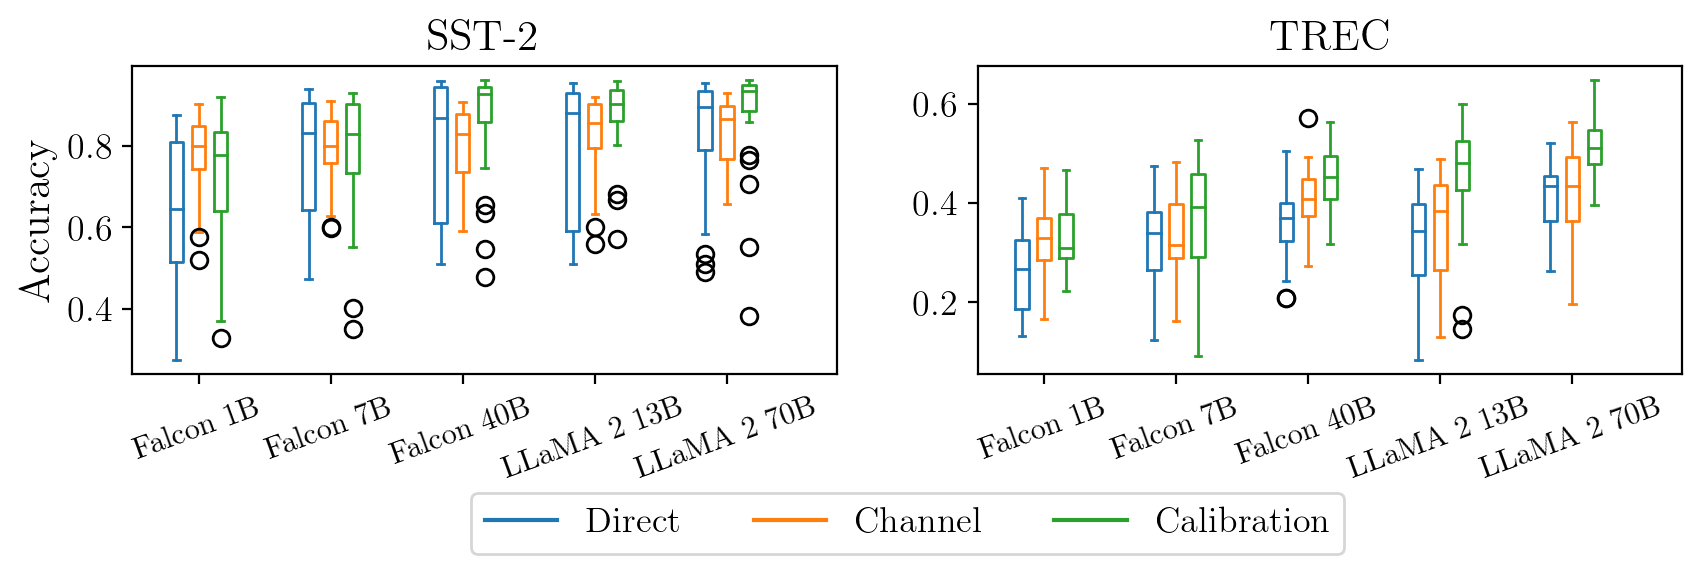

In [7]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 15,
        "font.size": 13,
        "legend.fontsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 13,
        "text.usetex": True,
})

fig = boxplot(main_models, figsize=[10, 2], datasets_range=['sst2', 'trec'], outliers=True, 
              orientation='horizontal', angle=20, bottom_sep=0.45)

In [8]:
import os
os.makedirs('figs', exist_ok=True)
fig.savefig("figs/prediction_methods_2_main_boxplots.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

## Boxplot for all models

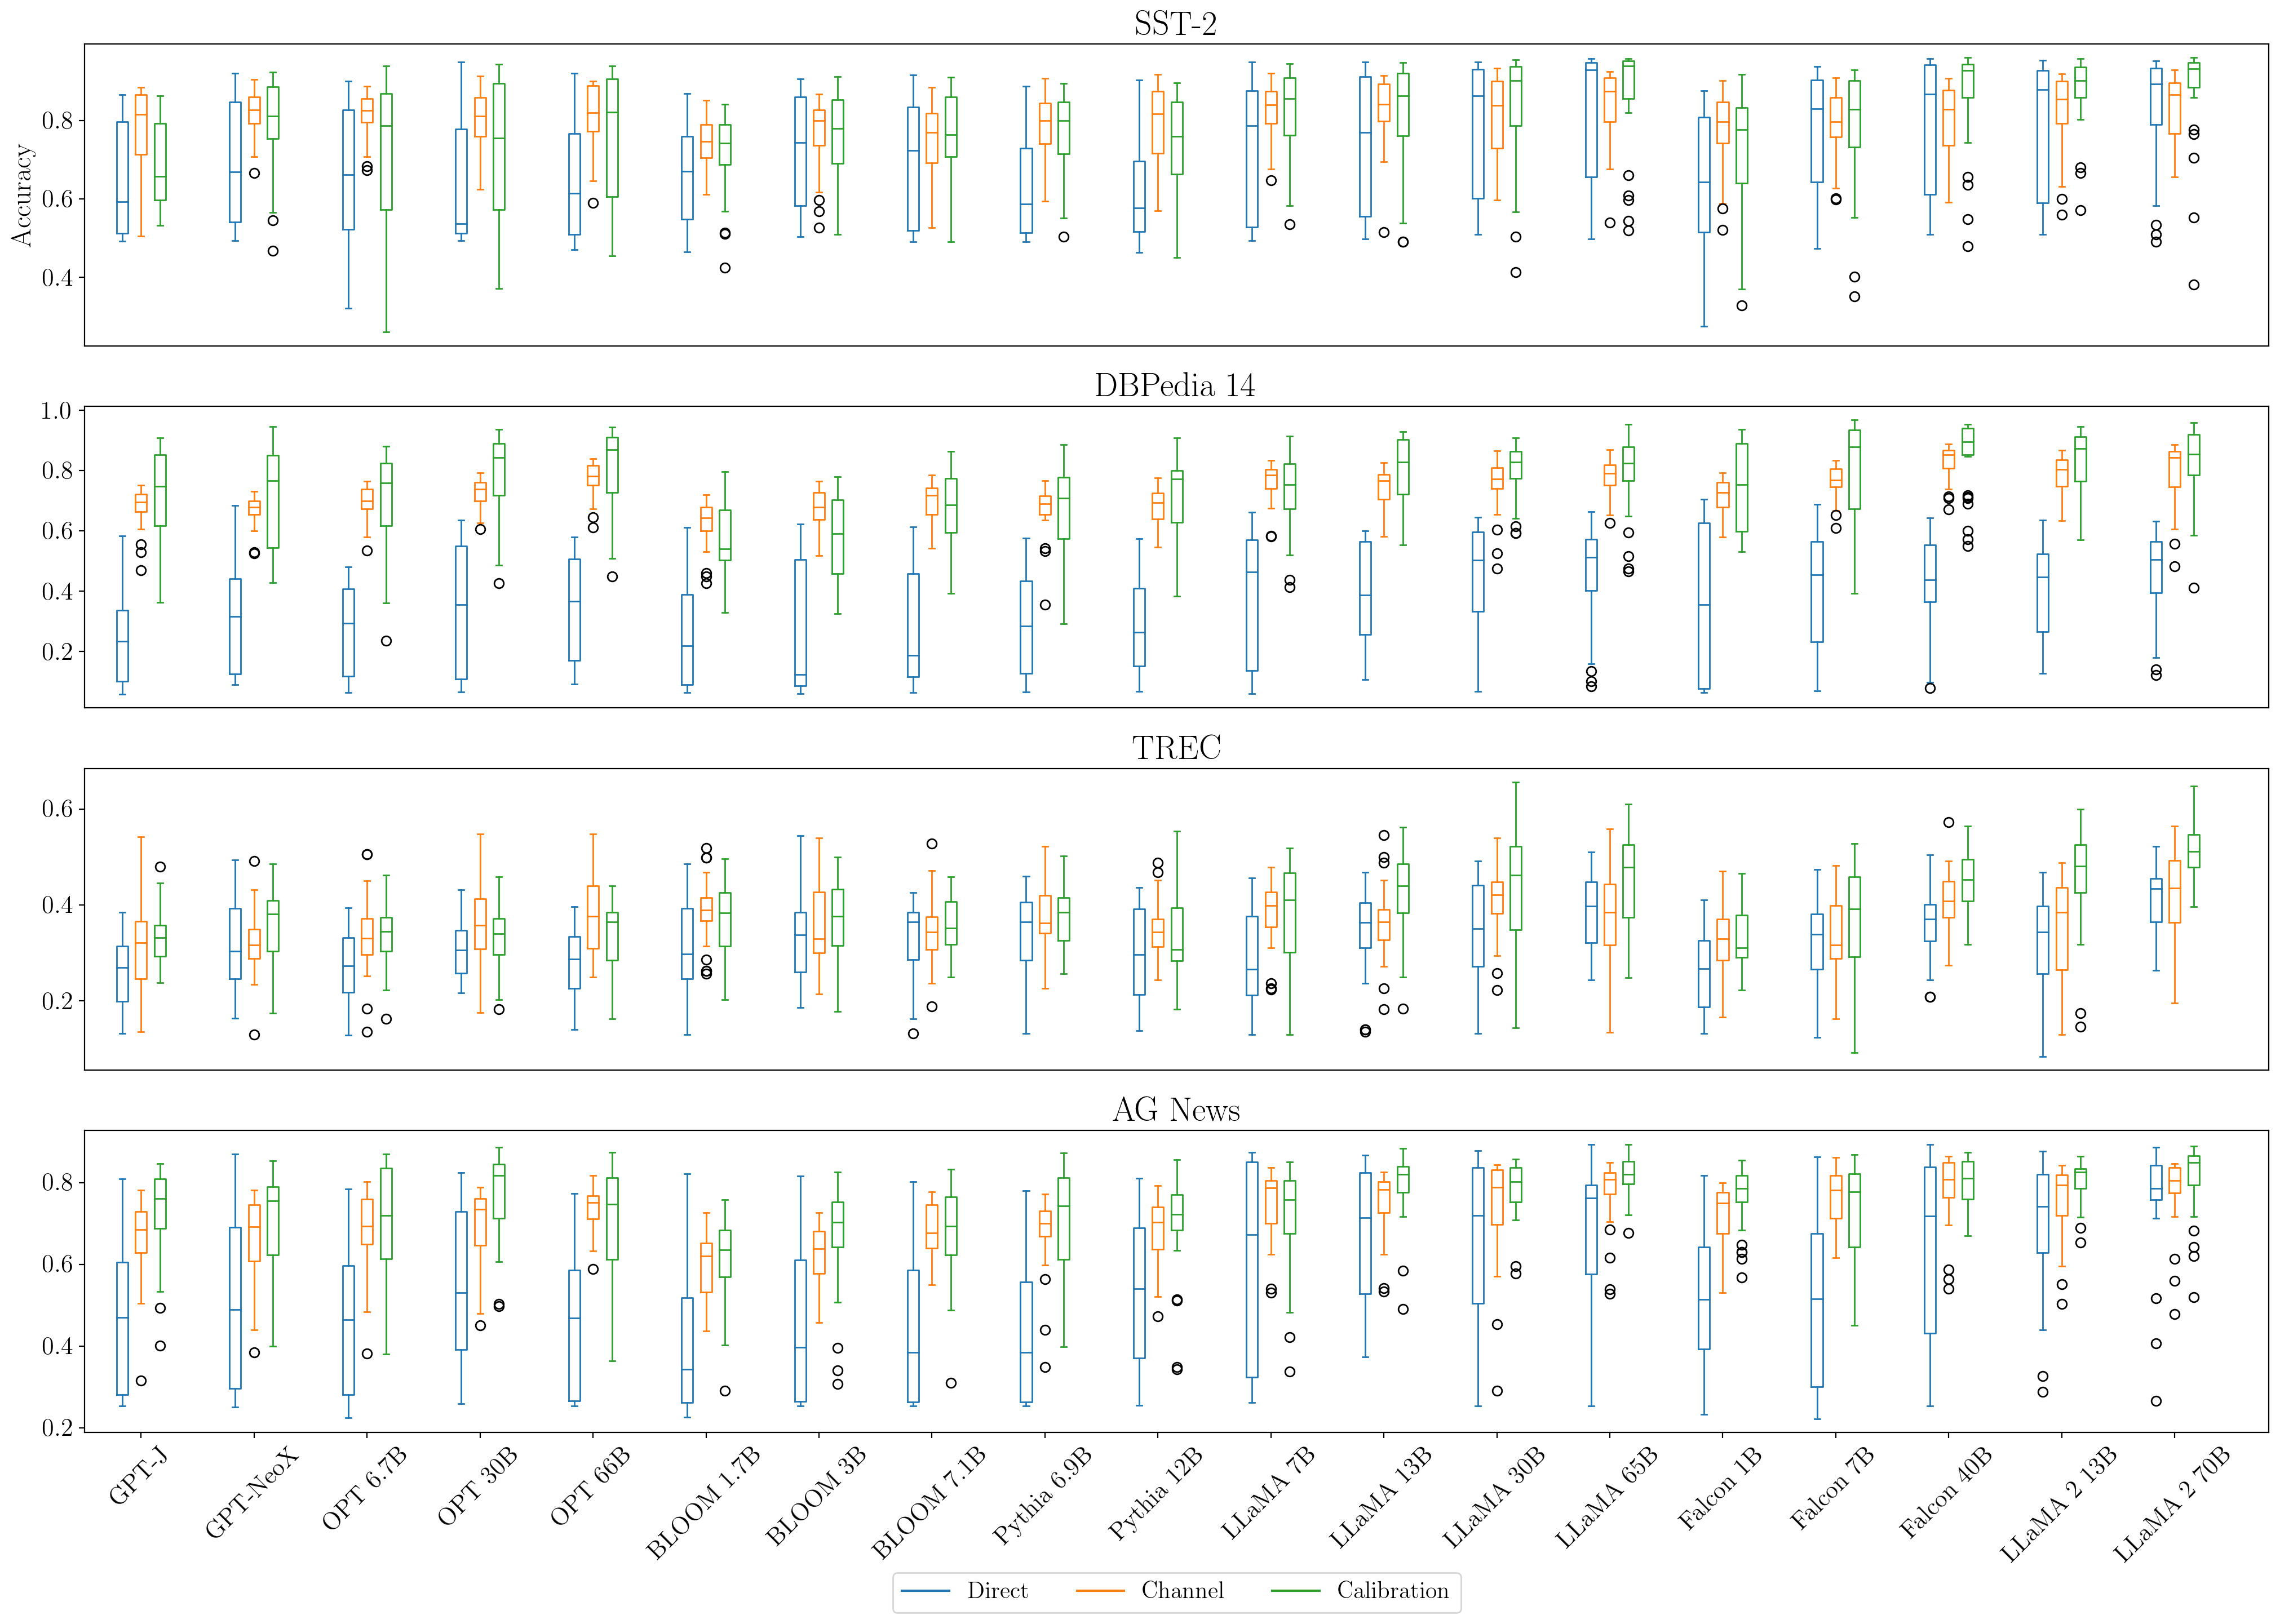

In [9]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 18,
        "font.size": 18,
        "legend.fontsize": 15,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "text.usetex": True,
})

fig = boxplot(figsize=[25, 16], datasets_range=datasets, orientation='vertical', outliers=True)

In [10]:
fig.savefig("figs/prediction_methods_full_2_boxplots.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

## Table 11. Comparison of the prediction methods on all datasets

In [11]:
from collections import Counter
from itertools import product

def method_wins(dataset,
                models_range=main_models,
                n_shots_range=[0, 2],
                methods_range=['direct_False', 'channel_True', 'calibrate_True'],
               ):
    iterate_over_pred_methods = 'direct_False' in methods_range
    mean_winners_counter, std_winners_counter = Counter(), Counter()
    
    for model, n_shots in product(models_range, n_shots_range):
        if n_shots == 0:
            seeds_range = [59]
        else:
            seeds_range = [59, 13, 21]
        
        methods_scores = {}
        for method in methods_range:
            if iterate_over_pred_methods:
                selection_method = ['random', '0-shot']
                prediction_method = method
            else:
                # iterate over selection method
                selection_method = method
                prediction_method = 'direct_False'
                
            config = {'dataset': dataset, 'model': model, 
                      'n_shots': n_shots, 'selection_method': selection_method,
                      'prediction_method': prediction_method, 'template_seed': 59,
                     }
            method_runs = get_runs(config)
            methods_scores[method] = get_scores(method_runs, config, seeds_range)
        
        mean_winner = np.argmax([np.mean(methods_scores[method]) for method in methods_range])
        std_winner = np.argmin([np.std(methods_scores[method]) for method in methods_range])

        mean_winners_counter[methods_range[mean_winner]] += 1
        std_winners_counter[methods_range[std_winner]] += 1

    return mean_winners_counter, std_winners_counter

In [12]:
tables_dataset = defaultdict(list)
methods = list(prediction_method_name)
n_shots_range = [0, 2]

models_range = model_name

print("""\\toprule
\\multirow{2}{*}{Model} & \\multirow{2}{*}{N} & \\multicolumn{3}{c}{SST-2} & 
\\multicolumn{3}{c}{DBPedia} & \\multicolumn{3}{c}{AGNews} & \\multicolumn{3}{c}{TREC} \\\\
\cmidrule(lr){3-5}\cmidrule(lr){6-8}\cmidrule(lr){9-11}\cmidrule(lr){12-14}
& & Direct & Channel & Calib. & Direct & Channel & Calib. & Direct & Channel & Calib. & 
Direct & Channel & Calib. \\\\
\\midrule""")
for model in models_range:
    if len(n_shots_range) > 1:
        print("\\multirow{2}{*}{", f"{model_name[model]}", "}", end=" & ", sep="")
    else:
        print(model_name[model], end=" & ")
    for n_shots in n_shots_range:
        if n_shots != n_shots_range[0]:
            print("&", end=" ")
        print(f"{n_shots} &", end=" ")
        for dataset in datasets:
            res_table_entry = {"model": f"{model_name[model]}-{n_shots}"}
            for method in prediction_method_name:
                config = {
                    'dataset': dataset, 'model': model, 'template_seed': 59,
                    'n_shots': n_shots, 'prediction_method': method, 'selection_method': ['0-shot', 'random'],
                }
                if n_shots == 0:
                    seeds_range = [59]
                else:
                    seeds_range = [59, 13, 21]
                method_res = report_scores(get_scores(get_runs(config), config, 
                                                      seeds_range=seeds_range, verbose=False),
                                           report="mean_std")
                res_table_entry.update({prediction_method_name[method]: 
                                        f"{method_res[0]:.2f} ± {method_res[1]:.2f}"})

                end = " \\\\\n" if (dataset == datasets[-1] and method == methods[-1]) else " & "
                print(format_res(method_res), end=end)
            tables_dataset[dataset].append(res_table_entry)
    if model in family_enders:
        print("\\midrule")
        
dataset_winners = {}
for dataset in datasets:
    dataset_winners[dataset] = method_wins(dataset, models_range, n_shots_range)
    
print('\midrule')
for i in range(2):
    print("\\multicolumn{2}{l}{", ["Highest mean, \%", "Lowest std, \%"][i], "}", sep="", end=" & ")
    for dataset in datasets:
        for method in prediction_method_name:
            res = dataset_winners[dataset][i][method] / sum(dataset_winners[dataset][i].values())
            end = '\\\\\n' if (method == methods[-1] and dataset == datasets[-1]) else " & "
            print(f"{res * 100:.1f}", end=end)

\toprule
\multirow{2}{*}{Model} & \multirow{2}{*}{N} & \multicolumn{3}{c}{SST-2} & 
\multicolumn{3}{c}{DBPedia} & \multicolumn{3}{c}{AGNews} & \multicolumn{3}{c}{TREC} \\
\cmidrule(lr){3-5}\cmidrule(lr){6-8}\cmidrule(lr){9-11}\cmidrule(lr){12-14}
& & Direct & Channel & Calib. & Direct & Channel & Calib. & Direct & Channel & Calib. & 
Direct & Channel & Calib. \\
\midrule
\multirow{2}{*}{GPT-J} & 0 & 0.71\textsubscript{0.09} & 0.68\textsubscript{0.08} & 0.68\textsubscript{0.08} & 0.41\textsubscript{0.07} & 0.44\textsubscript{0.06} & 0.57\textsubscript{0.08} & 0.32\textsubscript{0.05} & 0.20\textsubscript{0.07} & 0.33\textsubscript{0.04} & 0.61\textsubscript{0.08} & 0.64\textsubscript{0.03} & 0.64\textsubscript{0.07} \\
& 2 & 0.65\textsubscript{0.14} & 0.77\textsubscript{0.11} & 0.68\textsubscript{0.11} & 0.25\textsubscript{0.16} & 0.68\textsubscript{0.06} & 0.71\textsubscript{0.16} & 0.26\textsubscript{0.07} & 0.32\textsubscript{0.09} & 0.33\textsubscript{0.06} & 0.47\textsubscript{0.19

& 2 & 0.82\textsubscript{0.17} & 0.84\textsubscript{0.09} & 0.87\textsubscript{0.13} & 0.45\textsubscript{0.17} & 0.78\textsubscript{0.06} & 0.80\textsubscript{0.13} & 0.38\textsubscript{0.08} & 0.38\textsubscript{0.09} & 0.45\textsubscript{0.11} & 0.68\textsubscript{0.20} & 0.78\textsubscript{0.08} & 0.82\textsubscript{0.05} \\
\midrule
\multirow{2}{*}{Falcon 1B} & 0 & 0.72\textsubscript{0.08} & 0.72\textsubscript{0.03} & 0.73\textsubscript{0.07} & 0.54\textsubscript{0.03} & 0.55\textsubscript{0.04} & 0.62\textsubscript{0.10} & 0.24\textsubscript{0.04} & 0.25\textsubscript{0.04} & 0.31\textsubscript{0.02} & 0.68\textsubscript{0.04} & 0.64\textsubscript{0.06} & 0.63\textsubscript{0.08} \\
& 2 & 0.65\textsubscript{0.17} & 0.77\textsubscript{0.10} & 0.71\textsubscript{0.17} & 0.36\textsubscript{0.25} & 0.72\textsubscript{0.05} & 0.74\textsubscript{0.14} & 0.26\textsubscript{0.09} & 0.33\textsubscript{0.06} & 0.33\textsubscript{0.06} & 0.52\textsubscript{0.17} & 0.72\textsubscript{0.08} &

# Selection methods

## Figure 3

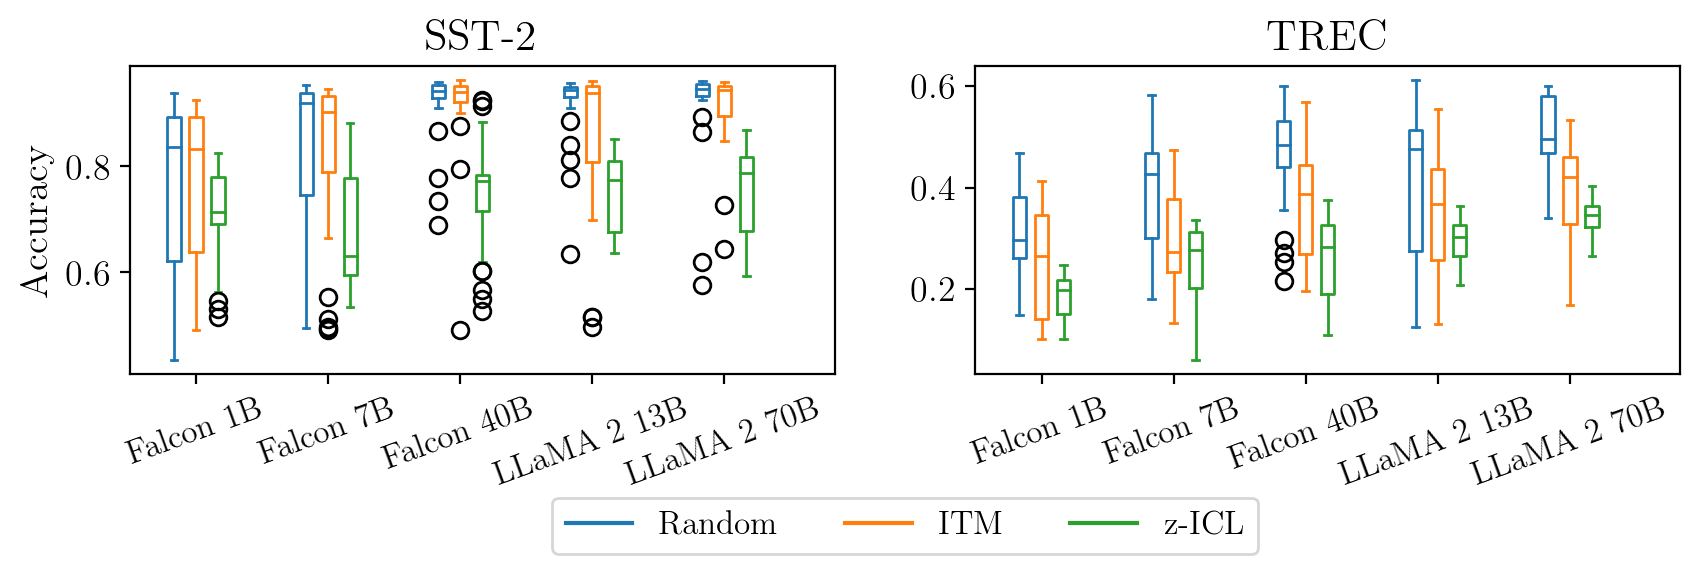

In [13]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 14,
        "font.size": 13,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 13,
        "text.usetex": True,
})

fig = boxplot(main_models, figsize=[10, 2], datasets_range=['sst2', 'trec'], outliers=True, n_shots=4,
              orientation='horizontal', angle=20, bottom_sep=0.45, methods_range=selection_method_name)

In [14]:
fig.savefig("figs/selection_methods_main_4_boxplots.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

## Table 12. Selection methods comparison on all models

In [16]:
from collections import defaultdict

tables_dataset = defaultdict(list)
n_shots_range = [4]
models_range = model_name

print("""\\toprule
\\multirow{2}{*}{Model} & 
\\multicolumn{3}{c}{SST-2} & \\multicolumn{3}{c}{DBPedia} & \\multicolumn{3}{c}{AGNews} & 
\\multicolumn{3}{c}{TREC} \\
\\cmidrule(lr){2-4}\\cmidrule(lr){5-7}\\cmidrule(lr){8-10}\\cmidrule(lr){11-13}
& Random & ITM & z-ICL & Random & ITM & z-ICL & Random & ITM & z-ICL & Random & ITM & z-ICL \\
\\midrule""")
for model in models_range:
    print(model_name[model], end=" & ")
    for n_shots in n_shots_range:
        for dataset in datasets:
            res_table_entry = {"model": model_name[model]}
            for method in selection_method_name:
            
                display_method_name = f"{selection_method_name[method]}-{n_shots}"
                config = {
                    'dataset': dataset, 
                    'model': model, 
                    'n_shots': n_shots,
                    'selection_method': method,
                    'prediction_method': 'direct_False',
                    'template_seed': 59,
                }
                method_res = report_scores(get_scores(get_runs(config), config, verbose=False),
                                           report="mean_std")
                res_table_entry.update({display_method_name: f"{method_res[0]:.2f} ± {method_res[1]:.2f}"})
                
                end = " \\\\\n" if (dataset == datasets[-1] and method == list(selection_method_name)[-1]) else " & "
                print(format_res(method_res), end=end)
            tables_dataset[dataset].append(res_table_entry)
    if model in family_enders:
        print("\\midrule")
print()
dataset_winners = {}
for dataset in datasets:
    dataset_winners[dataset] = method_wins(dataset, models_range, n_shots_range, 
                                           methods_range=list(selection_method_name))
print('\\midrule')
for i in range(2):
    print(["Highest mean, \%", "Lowest std, \%"][i], end=" & ")
    for dataset in datasets:
        for method in selection_method_name:
            res = dataset_winners[dataset][i][method] / sum(dataset_winners[dataset][i].values())
            end = '\\\\\n' if (method == list(selection_method_name)[-1] and dataset == datasets[-1]) else " & "
            print(f"{res * 100:.1f}", end=end)

\toprule
\multirow{2}{*}{Model} & 
\multicolumn{3}{c}{SST-2} & \multicolumn{3}{c}{DBPedia} & \multicolumn{3}{c}{AGNews} & 
\multicolumn{3}{c}{TREC} \
\cmidrule(lr){2-4}\cmidrule(lr){5-7}\cmidrule(lr){8-10}\cmidrule(lr){11-13}
& Random & ITM & z-ICL & Random & ITM & z-ICL & Random & ITM & z-ICL & Random & ITM & z-ICL \
\midrule
GPT-J & 0.66\textsubscript{0.14} & 0.73\textsubscript{0.16} & 0.66\textsubscript{0.05} & 0.34\textsubscript{0.18} & 0.46\textsubscript{0.17} & 0.24\textsubscript{0.10} & 0.36\textsubscript{0.11} & 0.25\textsubscript{0.10} & 0.21\textsubscript{0.04} & 0.48\textsubscript{0.23} & 0.59\textsubscript{0.12} & 0.45\textsubscript{0.11} \\
GPT-NeoX & 0.82\textsubscript{0.12} & 0.73\textsubscript{0.17} & 0.77\textsubscript{0.09} & 0.37\textsubscript{0.21} & 0.45\textsubscript{0.19} & 0.25\textsubscript{0.11} & 0.40\textsubscript{0.10} & 0.28\textsubscript{0.09} & 0.25\textsubscript{0.07} & 0.48\textsubscript{0.22} & 0.58\textsubscript{0.17} & 0.46\textsubscript{0.12} \\
\m

In [17]:
for dataset in datasets:
    print(dataset)
    display(pd.DataFrame(tables_dataset[dataset]))

sst2


,model,Random-4,ITM-4,z-ICL-4
0,GPT-J,0.66 ± 0.14,0.73 ± 0.16,0.66 ± 0.05
1,GPT-NeoX,0.82 ± 0.12,0.73 ± 0.17,0.77 ± 0.09
2,OPT 6.7B,0.80 ± 0.14,0.77 ± 0.18,0.72 ± 0.09
3,OPT 30B,0.79 ± 0.14,0.80 ± 0.16,0.79 ± 0.12
4,OPT 66B,0.84 ± 0.13,0.83 ± 0.15,0.75 ± 0.08
5,BLOOM 1.7B,0.67 ± 0.13,0.69 ± 0.14,0.64 ± 0.09
6,BLOOM 3B,0.76 ± 0.12,0.72 ± 0.15,0.62 ± 0.07
7,BLOOM 7.1B,0.74 ± 0.15,0.71 ± 0.15,0.62 ± 0.08
8,Pythia 6.9B,0.77 ± 0.14,0.72 ± 0.17,0.70 ± 0.10
9,Pythia 12B,0.81 ± 0.13,0.72 ± 0.18,0.79 ± 0.10


dbpedia


,model,Random-4,ITM-4,z-ICL-4
0,GPT-J,0.34 ± 0.18,0.46 ± 0.17,0.24 ± 0.10
1,GPT-NeoX,0.37 ± 0.21,0.45 ± 0.19,0.25 ± 0.11
2,OPT 6.7B,0.33 ± 0.18,0.46 ± 0.17,0.24 ± 0.11
3,OPT 30B,0.39 ± 0.19,0.50 ± 0.16,0.27 ± 0.11
4,OPT 66B,0.40 ± 0.16,0.48 ± 0.14,0.25 ± 0.10
5,BLOOM 1.7B,0.31 ± 0.20,0.39 ± 0.19,0.20 ± 0.07
6,BLOOM 3B,0.33 ± 0.21,0.43 ± 0.18,0.19 ± 0.08
7,BLOOM 7.1B,0.32 ± 0.21,0.44 ± 0.19,0.20 ± 0.08
8,Pythia 6.9B,0.35 ± 0.19,0.47 ± 0.17,0.22 ± 0.10
9,Pythia 12B,0.35 ± 0.16,0.46 ± 0.14,0.24 ± 0.10


trec


,model,Random-4,ITM-4,z-ICL-4
0,GPT-J,0.36 ± 0.11,0.25 ± 0.10,0.21 ± 0.04
1,GPT-NeoX,0.40 ± 0.10,0.28 ± 0.09,0.25 ± 0.07
2,OPT 6.7B,0.34 ± 0.10,0.23 ± 0.07,0.22 ± 0.05
3,OPT 30B,0.34 ± 0.10,0.25 ± 0.08,0.25 ± 0.06
4,OPT 66B,0.33 ± 0.09,0.25 ± 0.09,0.21 ± 0.04
5,BLOOM 1.7B,0.36 ± 0.11,0.26 ± 0.07,0.19 ± 0.06
6,BLOOM 3B,0.39 ± 0.12,0.29 ± 0.10,0.23 ± 0.03
7,BLOOM 7.1B,0.38 ± 0.10,0.32 ± 0.08,0.21 ± 0.05
8,Pythia 6.9B,0.38 ± 0.13,0.31 ± 0.08,0.22 ± 0.05
9,Pythia 12B,0.35 ± 0.12,0.30 ± 0.09,0.22 ± 0.04


agnews


,model,Random-4,ITM-4,z-ICL-4
0,GPT-J,0.48 ± 0.23,0.59 ± 0.12,0.45 ± 0.11
1,GPT-NeoX,0.48 ± 0.22,0.58 ± 0.17,0.46 ± 0.12
2,OPT 6.7B,0.47 ± 0.22,0.49 ± 0.17,0.45 ± 0.14
3,OPT 30B,0.61 ± 0.18,0.67 ± 0.14,0.54 ± 0.13
4,OPT 66B,0.53 ± 0.19,0.61 ± 0.15,0.48 ± 0.12
5,BLOOM 1.7B,0.42 ± 0.19,0.46 ± 0.16,0.45 ± 0.08
6,BLOOM 3B,0.46 ± 0.22,0.50 ± 0.16,0.43 ± 0.12
7,BLOOM 7.1B,0.41 ± 0.21,0.50 ± 0.17,0.42 ± 0.10
8,Pythia 6.9B,0.43 ± 0.20,0.56 ± 0.16,0.46 ± 0.12
9,Pythia 12B,0.46 ± 0.22,0.57 ± 0.16,0.44 ± 0.13


# Template Transfer

## Auxiliary functions

In [18]:
import json

dataset_templates = defaultdict(dict)
for dataset in dataset_name:
    with open(f'../predefined_templates/random/{dataset}.json') as handle:
        dataset_templates[dataset] = json.load(handle)

In [19]:
dataset_template_tables = {}

for dataset in dataset_name:
    table = {'inp_verbalizer': [], 'out_verbalizer': [], 'sep': [], 'big_sep': [], 'seed': [], 'n': []}
    for seed in dataset_templates[dataset]:
        for i, template in enumerate(dataset_templates[dataset][seed]):
            template = eval(template)
            for part in template.keys():
                table[part].append(template[part])
            table['seed'].append(seed)
            table['n'].append(i)
    dataset_template_tables[dataset] = pd.DataFrame(table)
    print(dataset)
    display(dataset_template_tables[dataset].sort_values(list(table.keys())[:-2]))

sst2


,inp_verbalizer,out_verbalizer,sep,big_sep,seed,n
25,input: {},A {} one.,\n,\n\n,21,5
7,input: {},A {} piece.,,\n,59,7
2,input: {},It was {}.,\n,\n,59,2
6,input: {},output: {},,\n\n,59,6
19,input: {},sentiment: {},\n,\n\n,13,9
23,input: {},sentiment: {},\n,,21,3
18,sentence: {},A {} one.,\n,\n\n,13,8
21,sentence: {},It was {}.,,\n,21,1
10,sentence: {},emotion: {},,\n\n,13,0
3,sentence: {},label: {},\n,\n\n,59,3


dbpedia


,inp_verbalizer,out_verbalizer,sep,big_sep,seed,n
2,input: {},It is about {}.,\n,\n,59,2
19,input: {},Subject: {}.,\n,\n\n,13,9
5,input: {},Subject: {}.,\n,,59,5
8,input: {},Subject: {}.,,\n\n,59,8
15,input: {},Topic: {}.,\n,\n\n,13,5
7,input: {},Topic: {}.,\n,,59,7
6,input: {},{},,\n\n,59,6
21,sentence: {},It is about {}.,,\n,21,1
18,sentence: {},This is about {}.,\n,\n\n,13,8
23,sentence: {},This is about {}.,,,21,3


trec


,inp_verbalizer,out_verbalizer,sep,big_sep,seed,n
2,input: {},It is about {}.,\n,\n,59,2
19,input: {},Subject: {}.,\n,\n\n,13,9
5,input: {},Subject: {}.,\n,,59,5
8,input: {},Subject: {}.,,\n\n,59,8
15,input: {},Topic: {}.,\n,\n\n,13,5
7,input: {},Topic: {}.,\n,,59,7
6,input: {},{},,\n\n,59,6
21,sentence: {},It is about {}.,,\n,21,1
18,sentence: {},This is about {}.,\n,\n\n,13,8
23,sentence: {},This is about {}.,,,21,3


agnews


,inp_verbalizer,out_verbalizer,sep,big_sep,seed,n
2,input: {},It is about {}.,\n,\n,59,2
19,input: {},Subject: {}.,\n,\n\n,13,9
5,input: {},Subject: {}.,\n,,59,5
8,input: {},Subject: {}.,,\n\n,59,8
15,input: {},Topic: {}.,\n,\n\n,13,5
7,input: {},Topic: {}.,\n,,59,7
6,input: {},{},,\n\n,59,6
21,sentence: {},It is about {}.,,\n,21,1
18,sentence: {},This is about {}.,\n,\n\n,13,8
23,sentence: {},This is about {}.,,,21,3


In [20]:
def get_toptemplates(config, return_k=5):
    all_scores, all_templates = [], []
    
    for template_seed in [59, 13, 21]:
        config['template_seed'] = template_seed
        runs = get_runs(config)
        scores = get_scores(runs, config, seeds_range=[59])
        if len(scores) == 0:
            continue

        for i, score in enumerate(scores[0]):
            template = dataset_templates[config['dataset']][str(template_seed)][i]

            if template not in all_templates:
                all_scores.append(score)
                all_templates.append(template)
        
    toptemplates = np.argsort(all_scores)[::-1]

    return toptemplates[:return_k]

def calc_iou(list_a, list_b, eps=1e-8):
    set_a = set(list_a)
    set_b = set(list_b)
    return (len(set_a.intersection(set_b)) + eps)/(len(set_a.union(set_b)) + eps)

## Figure 6. Accuracy deterioration

In [21]:
dataset_pos_stats = {}

for dataset in datasets:
    pos_stats = [[] for _ in range(30)]
    for model in model_name:
        for prediction_method in methods:
            all_scores, all_templates = [], []
            
            config = {'dataset': dataset, 'model': model, 'prediction_method': prediction_method,
                     'n_shots': 2, 'selection_method': 'random'}
            for template_seed in [59, 13, 21]:
                config['template_seed'] = template_seed
                runs = get_runs(config)
                scores = get_scores(runs, config, seeds_range=[59])
                if len(scores) == 0:
                    print(dataset, model, prediction_method, template_seed)

                for i, score in enumerate(scores[0]):
                    template = dataset_templates[config['dataset']][str(template_seed)][i]

                    if template not in all_templates:
                        all_scores.append(score)

            all_scores = np.array(sorted(all_scores, reverse=True))
            all_scores /= all_scores.max()
            for i in range(len(all_scores)):
                pos_stats[i].append(all_scores[i])
                
    dataset_pos_stats[dataset] = pos_stats

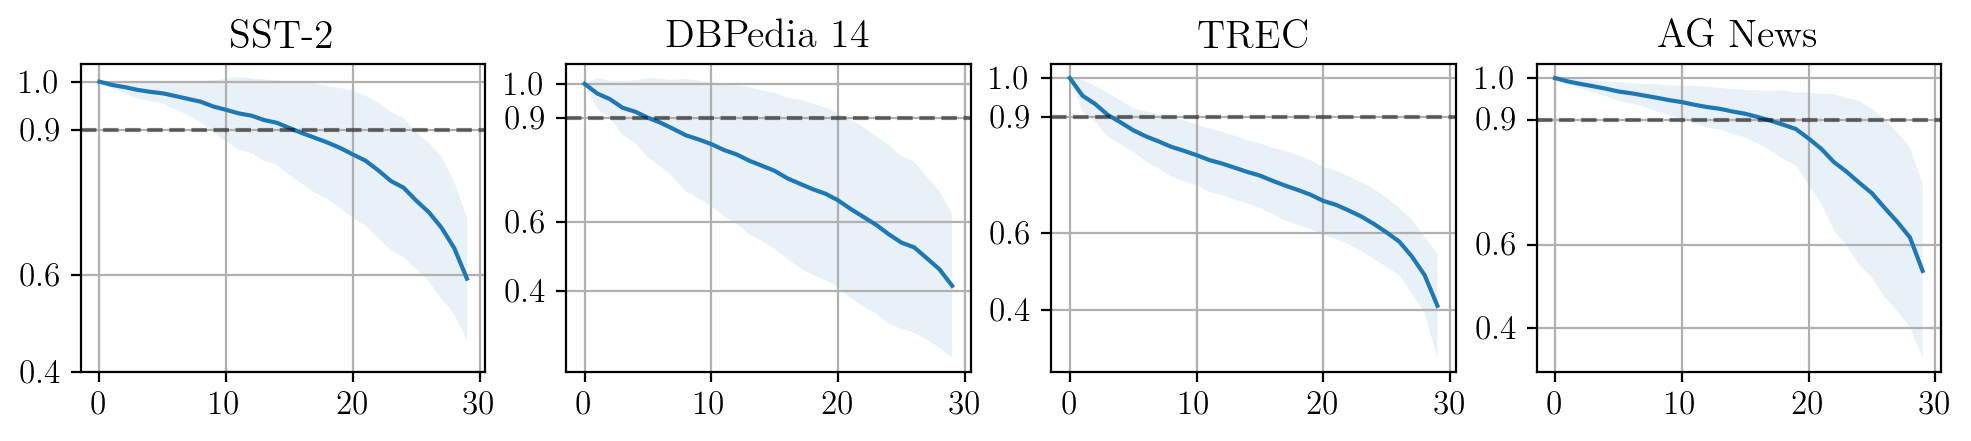

In [22]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 14,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True,
})

fig = plt.figure(figsize=[12, 2])
for i, dataset in enumerate(datasets, 1):
    plt.subplot(1, 4, i)
    pos_stats = np.array([x for x in dataset_pos_stats[dataset] if len(x) > 0])
    means, stds = np.mean(pos_stats, axis=1), np.std(pos_stats, axis=1)
    plt.plot(means)
    plt.axhline(0.9, c='black', alpha=0.5, ls='--')
    plt.fill_between(range(len(pos_stats)), means+stds, means-stds, alpha=0.1)
    plt.title(dataset_name[dataset])
    plt.xticks([0, 10, 20, 30])
    plt.yticks([0.4, 0.6, 0.9, 1])
    plt.grid()

In [23]:
fig.savefig('figs/accuracy_deterioration.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

## IoU of top-10 Templates

### Transfer between models

In [24]:
method_model_top_templates = {}
for prediction_method in prediction_method_name:
    method_model_top_templates[prediction_method] = defaultdict(dict)

    for dataset in datasets:
        for model in model_name:
            config = {
                'dataset': dataset, 'model': model, 'n_shots': 2,
                'selection_method':'random', 'prediction_method': prediction_method
            }
            method_model_top_templates[prediction_method][dataset][model] = get_toptemplates(config, 
                                                                                             return_k=10)
        
def transfer_matrices(model_range=model_name, dataset_range=datasets, func=calc_iou):
    keys = list(model_range.keys())
    datasets_matrices = {}
    for dataset in datasets:
        dataset_matrix = [[0 for _ in keys] for _ in keys]
        
        for i in range(len(dataset_matrix)):
            for j in range(len(dataset_matrix)):
                model_i_toptemplates = method_model_top_templates['direct_False'][dataset][keys[i]]
                model_j_toptemplates = method_model_top_templates['direct_False'][dataset][keys[j]]
                dataset_matrix[i][j] = func(model_i_toptemplates, model_j_toptemplates)
        datasets_matrices[dataset] = dataset_matrix
        
    return datasets_matrices

datasets_matrices = transfer_matrices()

## Figure 4. Transfer between models

In [25]:
import seaborn as sns
import matplotlib
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 10,
        "font.size": 14,
        "legend.fontsize": 15,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "text.usetex": True,
})

def one_heatmap(ax, dataset, rotation=60, title=None, keep_xticks=True,
               ha='center'):
    if title is not None:
        ax.set_title(title.format(dataset_name[dataset]))
    enders = []
    i_prev = 0
    for i, model in enumerate(model_name, 1):
        if model in list(family_enders) + ['llama-2-70b-hf']:
            ax.hlines(i, i_prev, i, colors='white')
            ax.vlines(i, i_prev, i, colors='white')
            if i_prev != 0:
                ax.hlines(i_prev, i_prev, i, colors='white')
                ax.vlines(i_prev, i_prev, i, colors='white')
            i_prev = i
    sns.heatmap(datasets_matrices[dataset],
                yticklabels=[model_name[x] for x in model_name],
                cmap=sns.color_palette("coolwarm", as_cmap=True),
                ax=ax,
               )
    if keep_xticks:
        ax.set_xticks([x + 0.5 for x in range(len(model_name.keys()))])
        ax.set_xticklabels(labels=[model_name[x] for x in model_name], rotation=rotation, ha=ha)
    else:
        ax.set_xticks([])
    return ax

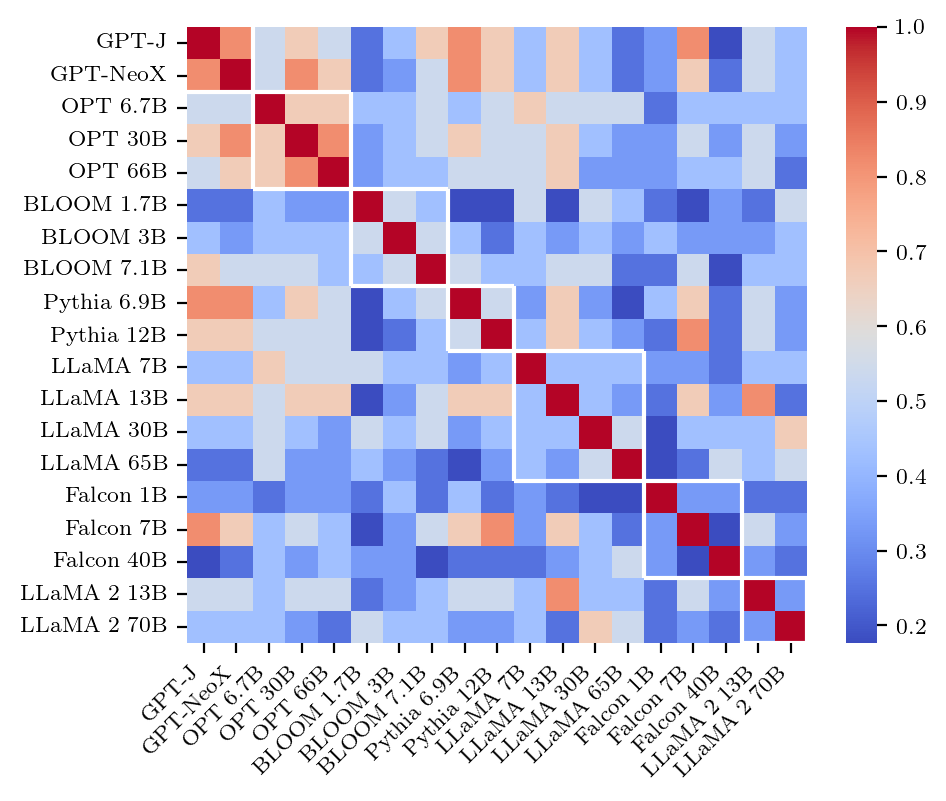

In [26]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = one_heatmap(ax, 'dbpedia', rotation=45, ha='right')

In [27]:
fig.savefig('figs/transfer_models_iou_main.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

## Figure 10. All datasets

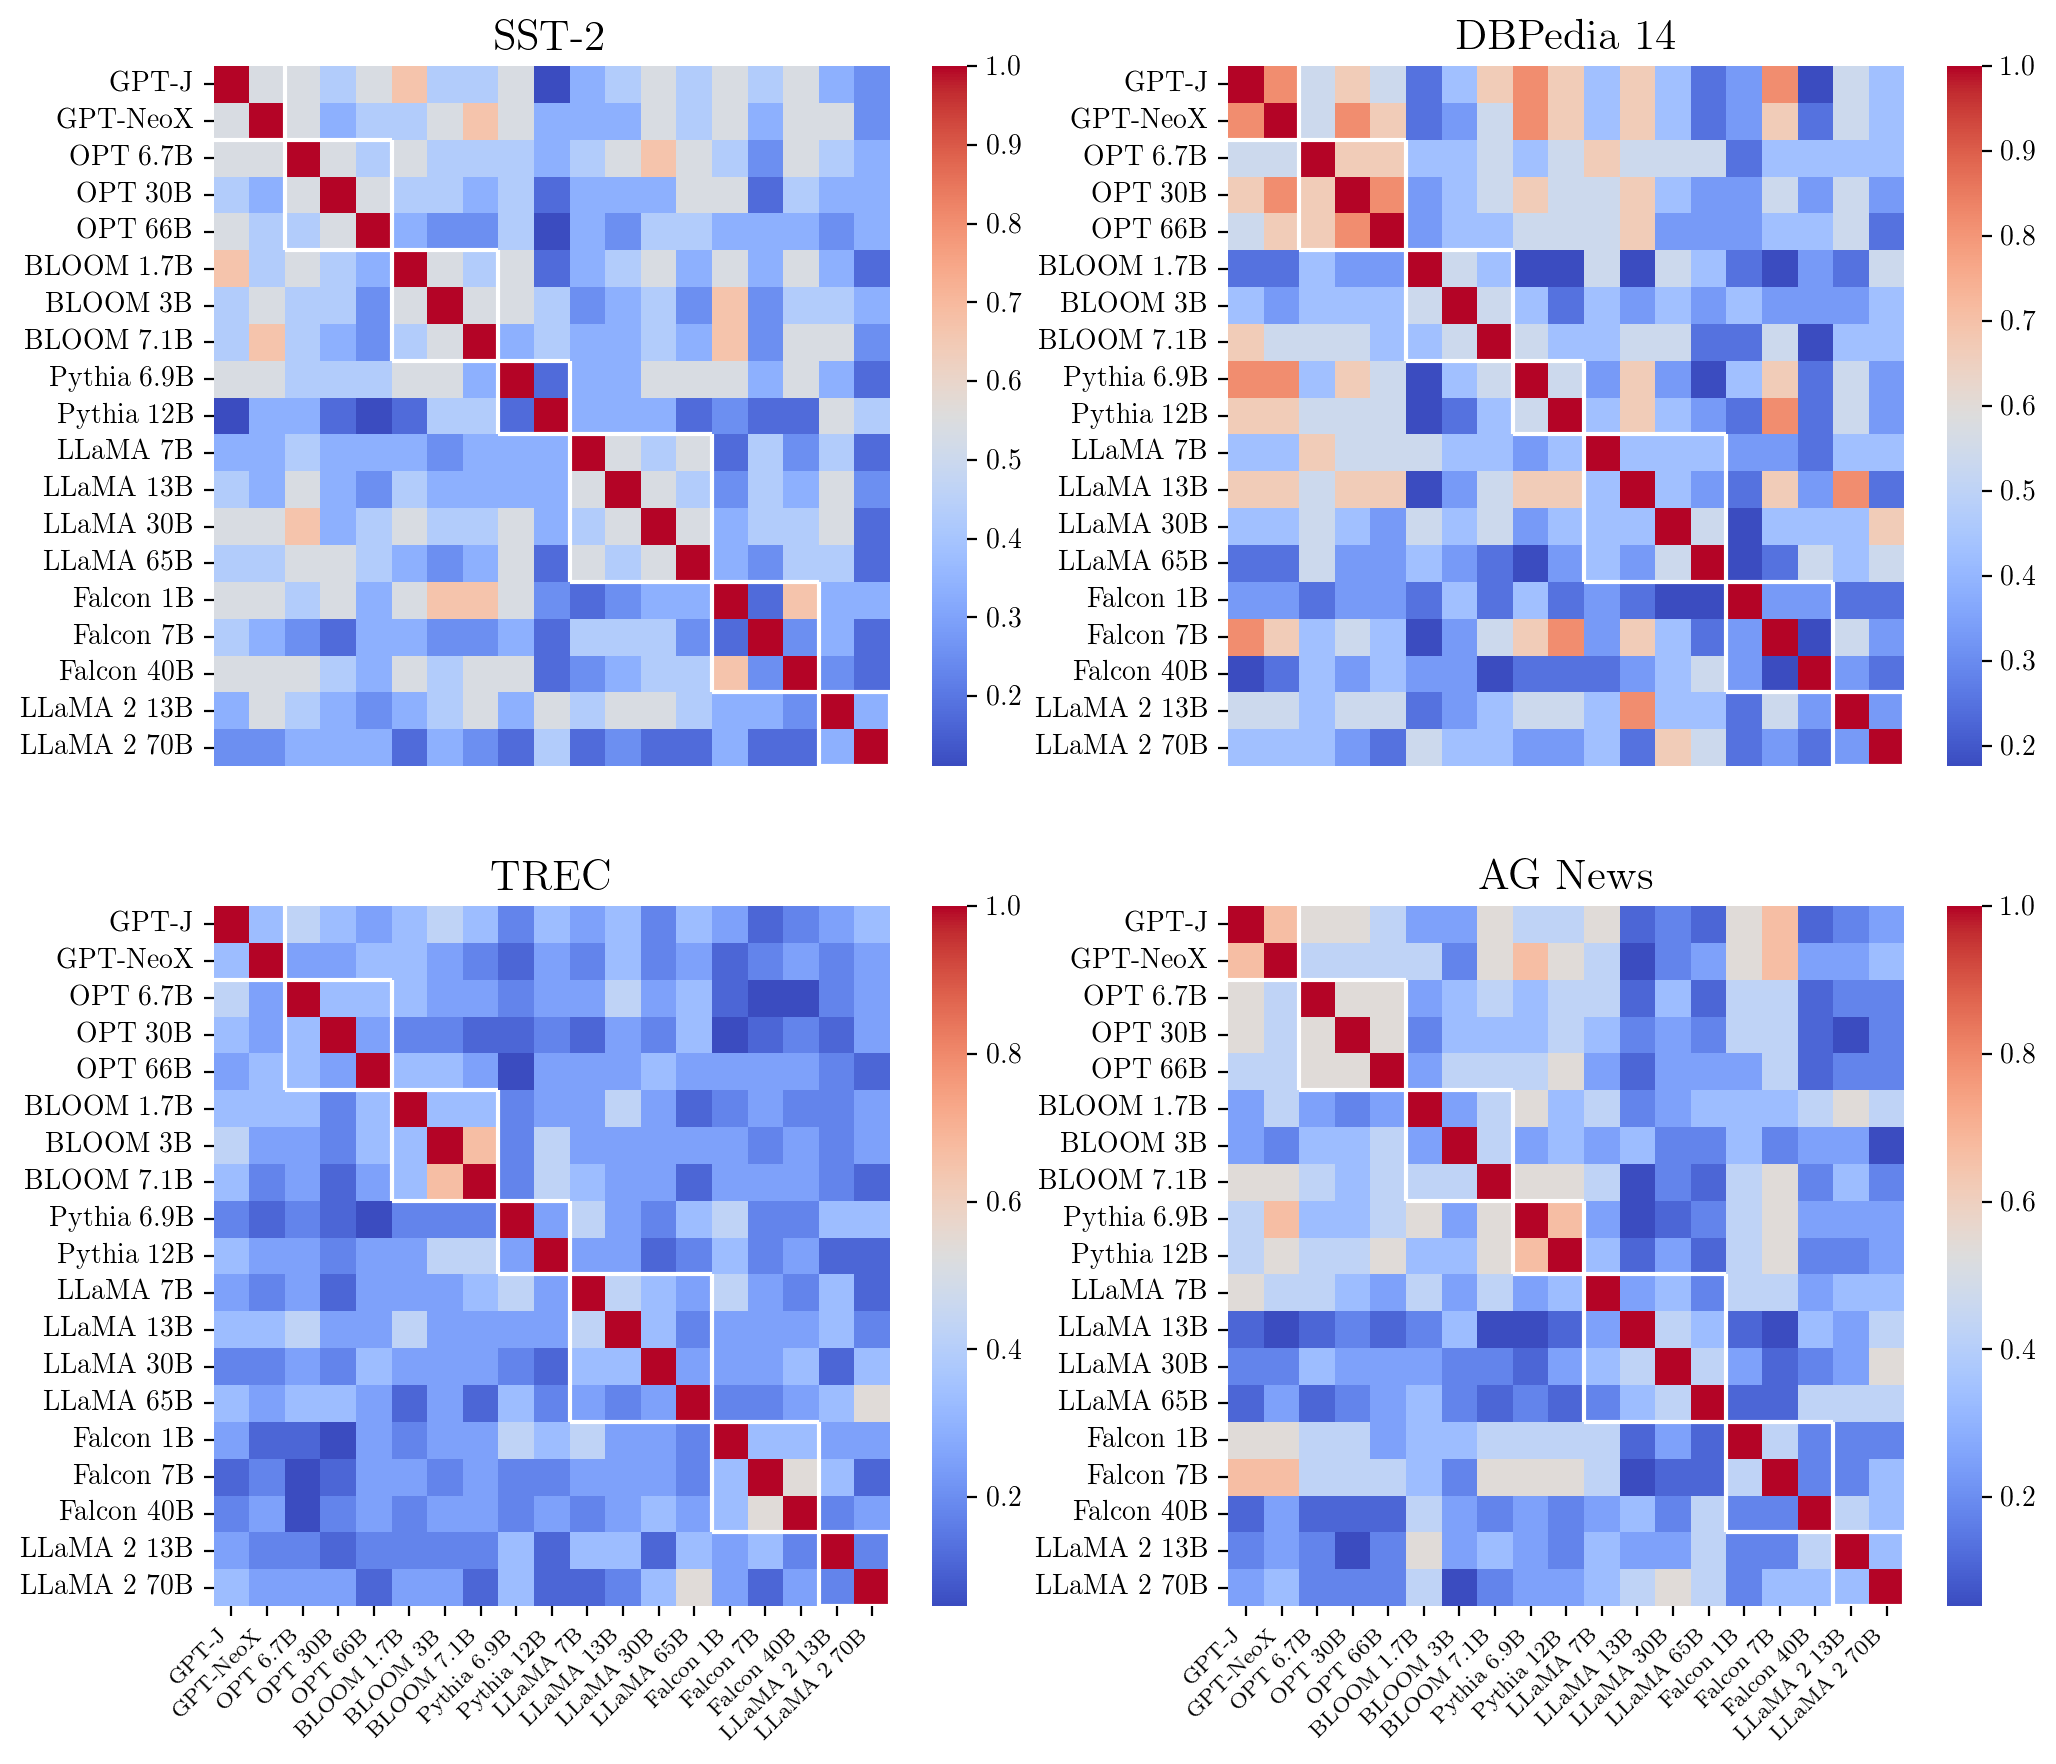

In [28]:
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 10,
        "font.size": 13,
        "legend.fontsize": 15,
        "xtick.labelsize": 8,
        "ytick.labelsize": 10,
        "text.usetex": True,
})
fig, axes = plt.subplots(figsize=[12, 10], nrows=2, ncols=2)
axes = axes.flatten()
for i, ax in enumerate(axes):
    keep_xticks = i > 1
    ax = one_heatmap(ax, datasets[i], rotation=45, title="{}", keep_xticks=keep_xticks, ha='right')

In [29]:
fig.savefig('figs/transfer_models_iou_full.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

## Figure 9. Spearman Correlation of all templates

In [30]:
from scipy.stats import spearmanr

datasets_matrices = {}
for dataset in datasets:
    datasets_matrices[dataset] = [[0 for _ in range(len(model_name))] for _ in range(len(model_name))]
    for i, model_i in enumerate(model_name):
        for j, model_j in enumerate(model_name):
            model_i_scores = []
            model_j_scores =[]
            
            seeds_range = [59, 13, 21]
                
            for template_seed in seeds_range:
                config = {'dataset': dataset, 'model': model_i, 'n_shots':2, 
                          'prediction_method':'direct_False', 'selection_method': 'random', 
                          'template_seed': template_seed,
                         }            
                for score in get_scores(get_runs(config), config, seeds_range=[59], verbose=False):
                    model_i_scores.extend(score)

                config = {'dataset': dataset, 'model': model_j, 'n_shots':2, 
                          'prediction_method':'direct_False', 'selection_method': 'random',
                          'template_seed': template_seed,
                }
                for score in get_scores(get_runs(config), config, seeds_range=[59], verbose=False):
                    model_j_scores.extend(score)
            datasets_matrices[dataset][i][j] = spearmanr(model_i_scores, model_j_scores).statistic

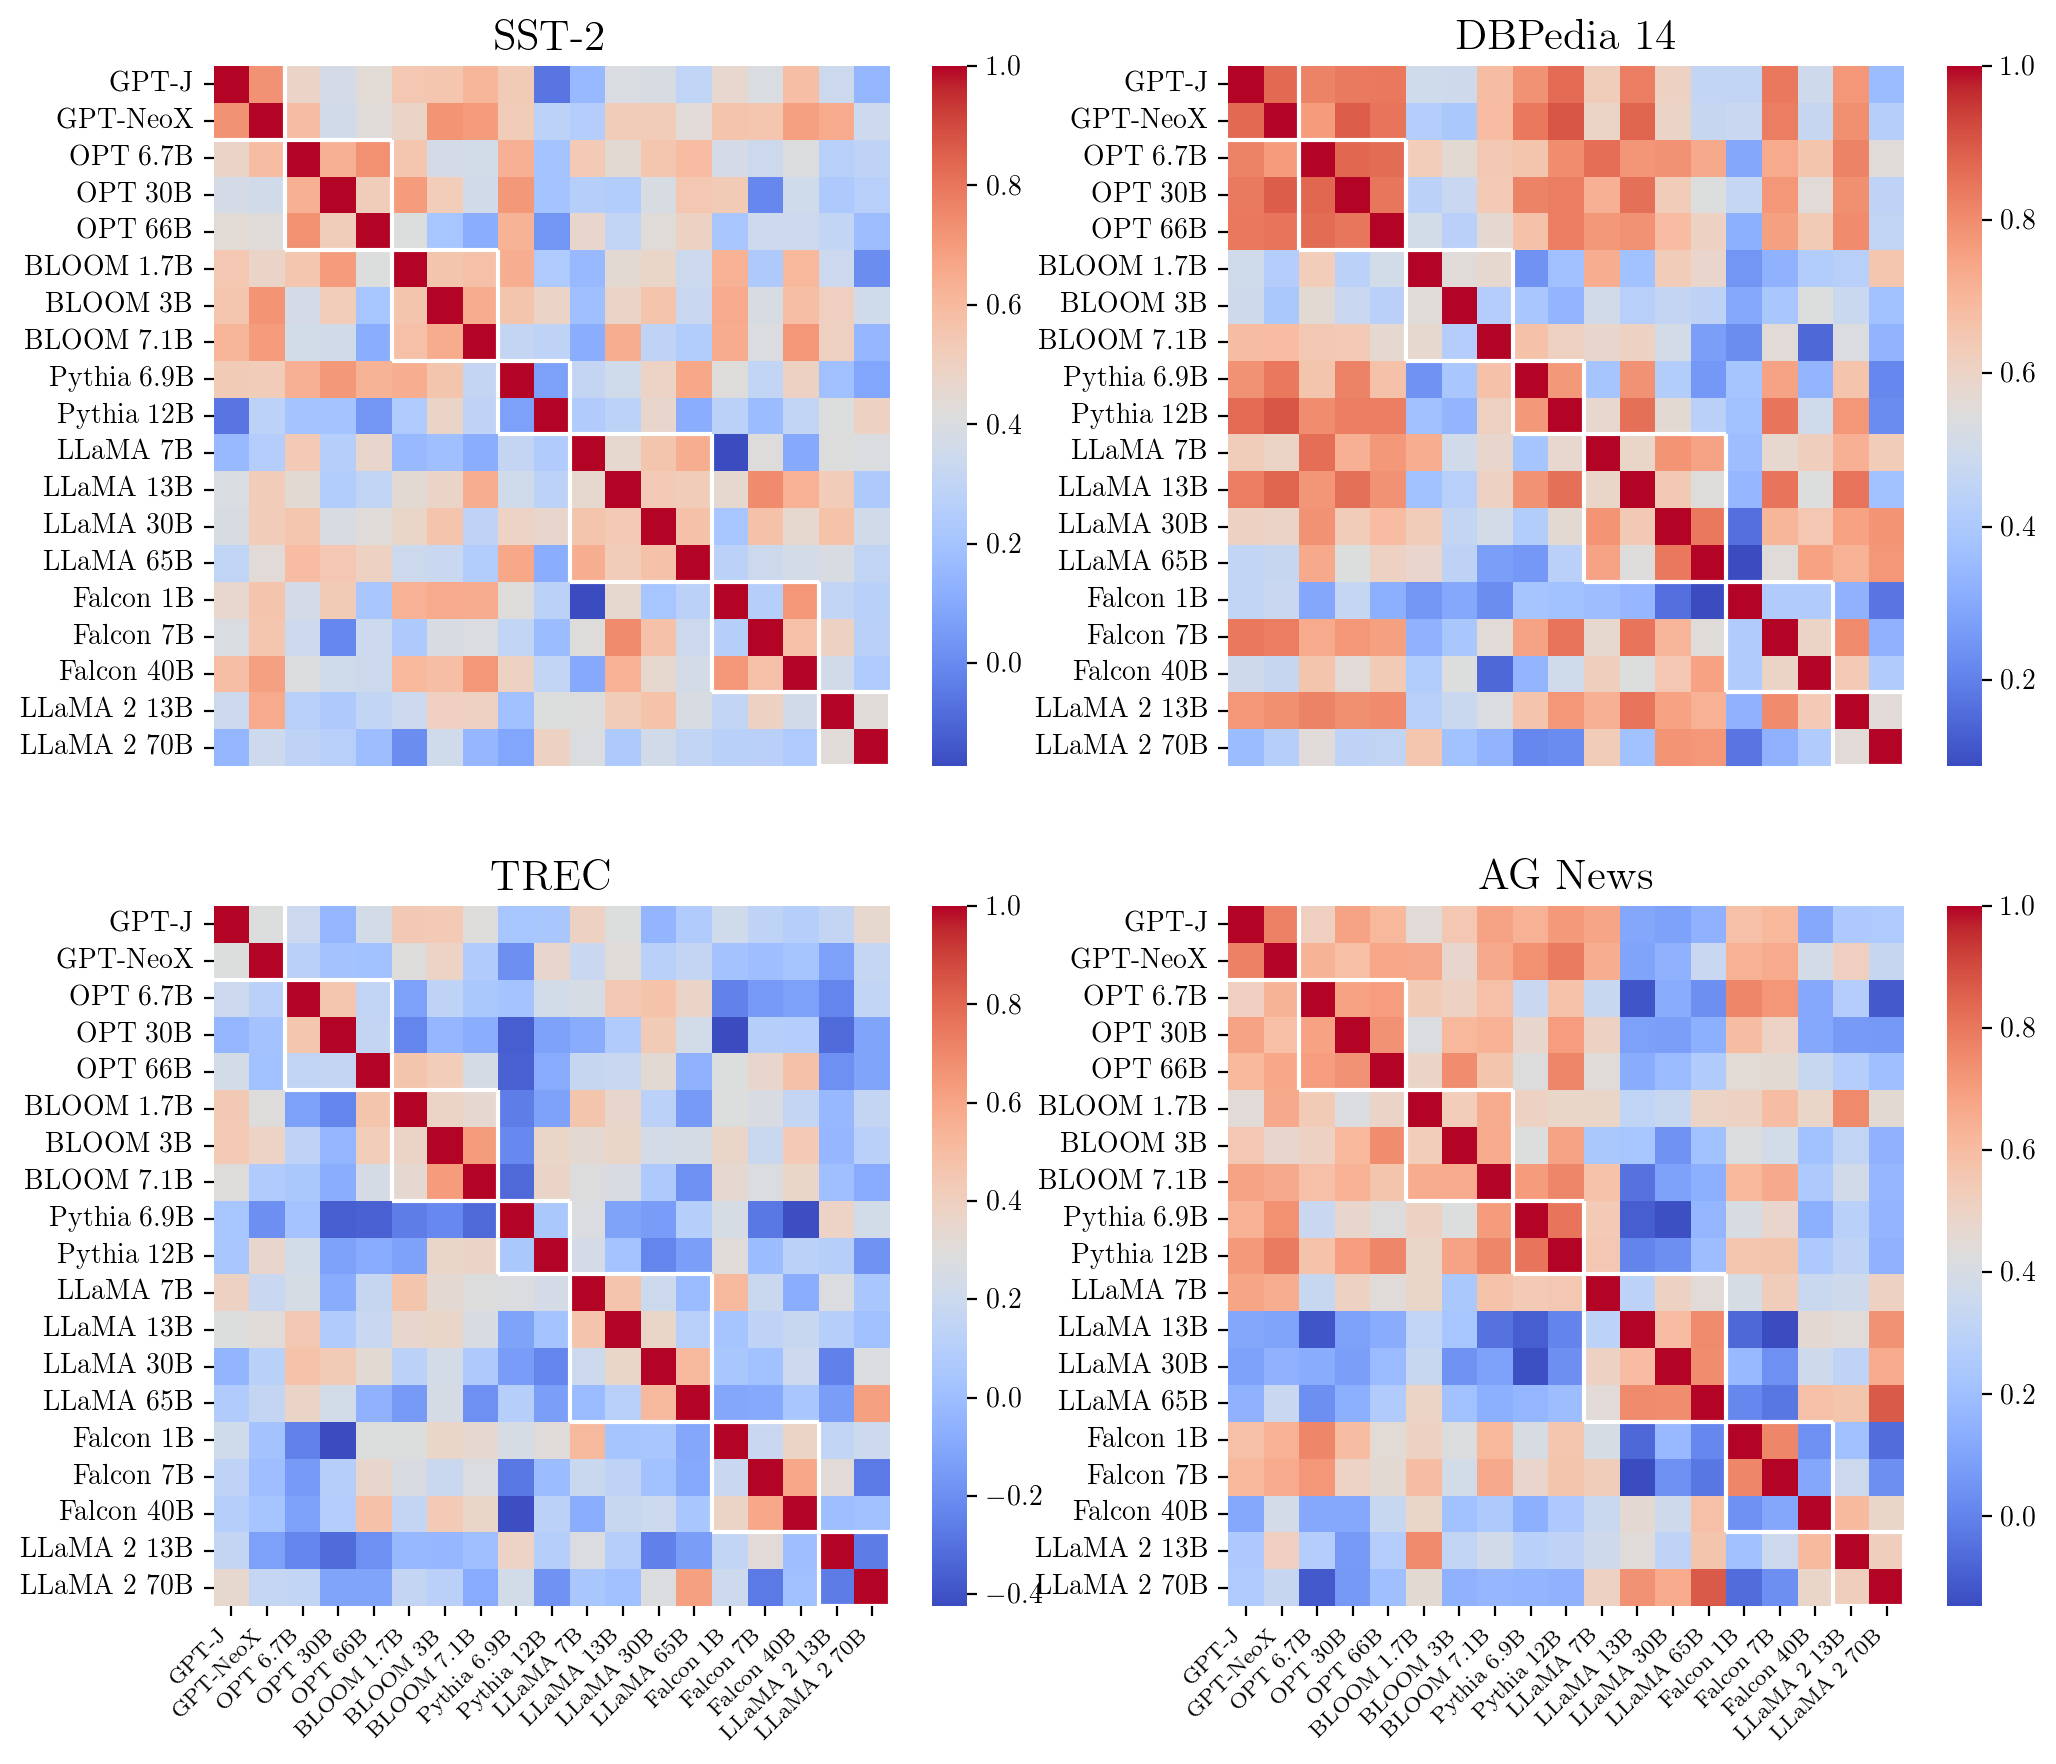

In [31]:
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 10,
        "font.size": 13,
        "legend.fontsize": 15,
        "xtick.labelsize": 8,
        "ytick.labelsize": 10,
        "text.usetex": True,
})
fig, axes = plt.subplots(figsize=[12, 10], nrows=2, ncols=2)
axes = axes.flatten()
for i, ax in enumerate(axes):
    keep_xticks = i > 1
    ax = one_heatmap(ax, datasets[i], rotation=45, title="{}", keep_xticks=keep_xticks, ha='right')

In [32]:
fig.savefig('figs/transfer_models_spearman.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

## Table 4. Transfer between prediction methods

In [33]:
print("""\\toprule
\\multirow{2}{*}{} & Direct $\\leftrightarrow$ & Direct $\\leftrightarrow$ & Channel $\\leftrightarrow$\\\\
& Calibration & Channel &  Calibration \\\\
\\midrule""")
for dataset in datasets:
    print(dataset_name[dataset], end=" & ")
    pairs = [('direct_False', 'calibrate_True'), ('direct_False', 'channel_True'), 
             ('channel_True', 'calibrate_True')]
    for pair in pairs:
        res = []
        for model in model_name:
            res.append(calc_iou(method_model_top_templates[pair[0]][dataset][model],
                                method_model_top_templates[pair[1]][dataset][model],
                               )
                      )
        end = "\\\\\n" if pair == pairs[-1] else " & "
        print(f"{np.mean(res):.2f}\\textsubscript{{{np.std(res):.2f}}}", end=end)

\toprule
\multirow{2}{*}{} & Direct $\leftrightarrow$ & Direct $\leftrightarrow$ & Channel $\leftrightarrow$\\
& Calibration & Channel &  Calibration \\
\midrule
SST-2 & 0.49\textsubscript{0.17} & 0.30\textsubscript{0.11} & 0.31\textsubscript{0.08}\\
DBPedia 14 & 0.54\textsubscript{0.17} & 0.47\textsubscript{0.15} & 0.45\textsubscript{0.14}\\
TREC & 0.31\textsubscript{0.12} & 0.23\textsubscript{0.09} & 0.28\textsubscript{0.13}\\
AG News & 0.36\textsubscript{0.11} & 0.25\textsubscript{0.13} & 0.35\textsubscript{0.14}\\


## Figure 5. Transfer between selection methods

In [34]:
from collections import defaultdict


method_model_top_templates = {}
for selection_method in selection_method_name:
    for n_shots in [2, 4]:
        display_method_name = f'{selection_method}-{n_shots}'
        method_model_top_templates[display_method_name] = defaultdict(dict)

        for dataset in datasets:
            for model in model_name:
                config = {
                    'dataset': dataset, 'model': model, 'n_shots': n_shots,
                    'selection_method': selection_method, 'prediction_method': 'direct_False'
                }
                method_model_top_templates[display_method_name][dataset][model] = get_toptemplates(config, 
                                                                                                   return_k=5)
        

datasets_matrices = {}
for dataset in datasets:
    keys = list(method_model_top_templates)
    dataset_matrix = [[0 for _ in keys] for _ in keys]

    for i in range(len(dataset_matrix)):
        for j in range(len(dataset_matrix)):
            for model in model_name:
                method_i_toptemplates = method_model_top_templates[keys[i]][dataset][model]
                method_j_toptemplates = method_model_top_templates[keys[j]][dataset][model]
                dataset_matrix[i][j] += calc_iou(method_i_toptemplates, method_j_toptemplates)
            dataset_matrix[i][j] /= len(model_name)
    datasets_matrices[dataset] = dataset_matrix

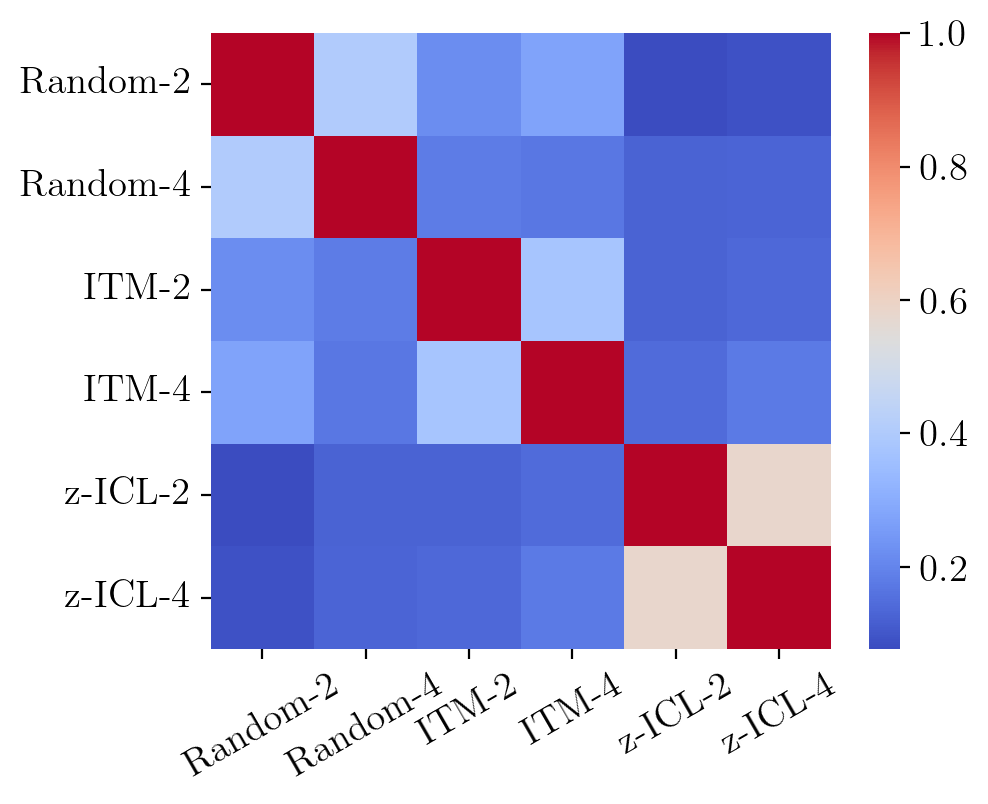

In [35]:
import seaborn as sns
import matplotlib
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 10,
        "font.size": 14,
        "legend.fontsize": 15,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "text.usetex": True,
})
import matplotlib.pyplot as plt

transform_name = {'random-2': "Random-2", 'random-4': "Random-4", 
                  'implicitly_topic_models-2': 'ITM-2', 'implicitly_topic_models-4': 'ITM-4',
                 'z-ICL-2': 'z-ICL-2', 'z-ICL-4': 'z-ICL-4',
                 }
def one_heatmap(ax, dataset, rotation=60, title_format="Template Transfer on {}", keep_yticks=True,
               ha='center', cbar=True):
    if title_format is not None:
        ax.set_title(title_format.format(dataset_name[dataset]))
    sns.heatmap(datasets_matrices[dataset],
                yticklabels=[transform_name[x] for x in method_model_top_templates],
                cmap=sns.color_palette("coolwarm", as_cmap=True),
                ax=ax, cbar=cbar,
               )
    if keep_yticks:
        ax.set_yticks([x + 0.5 for x in range(len(method_model_top_templates.keys()))])
        ax.set_yticklabels(labels=[transform_name[x] for x in method_model_top_templates], 
#                            rotation=rotation, ha=ha,
                          )
    else:
        ax.set_yticks([])
    ax.set_xticklabels(labels=[transform_name[x] for x in method_model_top_templates], 
                           rotation=rotation, ha=ha,
                      )
    return ax

fig, ax = plt.subplots(figsize=[5, 4])
ax = one_heatmap(ax, 'agnews', rotation=30, ha='center', cbar=True, title_format=None)

In [36]:
fig.savefig('figs/transfer_selections_iou_agnews.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

### All datasets

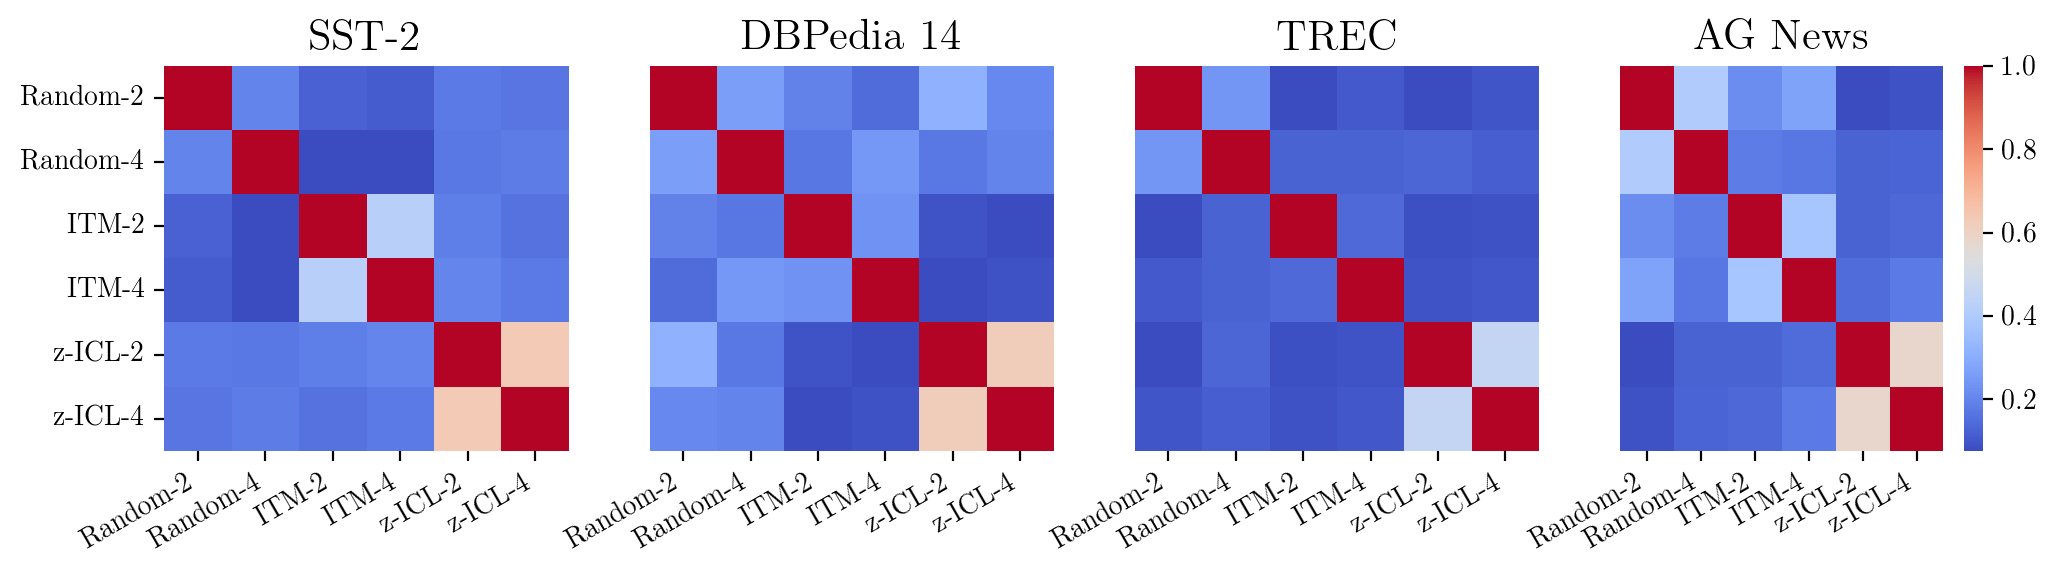

In [37]:
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": 10,
        "font.size": 13,
        "legend.fontsize": 15,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "text.usetex": True,
})
fig, axes = plt.subplots(figsize=[12, 2.5], nrows=1, ncols=4, sharex=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    keep_yticks = i < 1
    cbar = i == 3
    ax = one_heatmap(ax, datasets[i], rotation=30, title_format="{}", keep_yticks=keep_yticks, ha='right',
                    cbar=cbar)

In [38]:
fig.savefig('figs/transfer_selections_iou_all.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

## Parse runs from scratch

The code belows allows you to parse runs from your WandB project.

In [ ]:
from wandb.apis.public import Api

WANDB_KEY = <your WandB API key>
PROJECT = <name of your WandB project>

wandb_api = Api(api_key=WANDB_KEY)
project = wandb_api.runs(PROJECT)

In [ ]:
from tqdm import tqdm
import pandas as pd


runs = []

for run in tqdm(project):
    if run.state == 'finished':
            
        config = run.config
        history = run.history()

        if len(history) > 0:
            scores = history.scores.item()
            # if run was on a single template cast to list for consistency with other runs
            if isinstance(scores, float):
                scores = [scores]
            
            config.update({'scores': scores})
            
            runs.append(config)

runs_df = pd.DataFrame(runs)
runs_df.rename({'example_selection_method': 'selection_method'}, axis=1, inplace=True)
# optionally save to csv
# runs_df.to_csv('your_runs.csv', index=False)